In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold,RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (
accuracy_score,
classification_report,
confusion_matrix,
roc_curve,
auc,
f1_score,
make_scorer
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline


In [5]:
#Load Cleaned dataset
train_df = pd.read_csv('../data/clean/train_split.csv')
train_df.head()

,WaitTime,ServiceRating,FoodRating,AmbianceRating,AverageSpend,VisitFrequency,LoyaltyProgramMember,OnlineReservation,DeliveryOrder,GroupSize,TimeOfVisit,HighSatisfaction
0,26.678848,4,2,3,167.733275,3,1,1,0,5,1,0
1,23.408164,1,1,4,48.884673,2,0,0,0,5,3,0
2,1.327233,5,3,4,14.930917,3,1,0,1,5,3,0
3,34.344589,5,2,1,97.284161,3,1,0,0,4,2,0
4,23.570177,1,5,2,15.680247,4,0,0,0,2,1,0


In [6]:
print("Shape:", train_df.shape)
train_df['HighSatisfaction'].value_counts(normalize=True)

Shape: (1200, 12)


HighSatisfaction
0    0.865833
1    0.134167
Name: proportion, dtype: float64

In [7]:
#Split into X and y
X_full = train_df.drop(columns=['HighSatisfaction'])
y_full = train_df['HighSatisfaction']
#Split 80/20 training and validation
X_train, X_val, y_train, y_val = train_test_split(
X_full, y_full,
test_size=0.2,
stratify=y_full,
random_state=42
)
print("Training:", X_train.shape, "Validation:", X_val.shape)

Training: (960, 11) Validation: (240, 11)


In [10]:
#Data Visualization Functions
def confusion_bar(y_true, y_pred, title):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    labels = ['TN', 'FP', 'FN', 'TP']
    values = [tn, fp, fn, tp]
    plt.figure(figsize=(7,5))
    bars = plt.bar(labels, values, color=['green','red','red','green'])
    for i, bar in enumerate(bars):
        plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.5,str(values[i]), ha='center')
    plt.title(title)
    plt.show()


def plot_roc_curve(y_true, y_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.show()


def plot_feature_importance(model, X, title):
    importances = model.feature_importances_
    feat_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
    }).sort_values("Importance", ascending=False)
    plt.figure(figsize=(8,6))
    sns.barplot(x="Importance", y="Feature", data=feat_df)
    plt.title(title)
    plt.show()
    return feat_df

In [11]:
#count the occurences of the majority and minority class
neg, pos = y_train.value_counts()
pos_weight = neg / pos # used later in XGB tuning scale_pos_weight

print(f"Majority class: {neg}, Minority class: {pos}")
print(f"Approximate positive class weight: {pos_weight:.2f}")

Majority class: 831, Minority class: 129
Approximate positive class weight: 6.44


In [12]:
#Choosing a better metric for imbalanced classification , telling sklearn to judge the models based on how well they detect the minority class
f1_positive = make_scorer(f1_score, pos_label=1)

In [13]:
# Pipeline ensures oversampling happens *inside* each CV fold (prevents data leakage)

rf_pipeline = Pipeline([
    ("oversample", RandomOverSampler(random_state=42)),
    ("rf", RandomForestClassifier(random_state=42))
])

# Hyperparameter search space for Random Forest
rf_param_dist = {
    "rf__n_estimators": [100, 200, 300, 500],
    "rf__max_depth": [None, 5, 10, 15],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["sqrt", "log2", None],
    "rf__class_weight": [None, "balanced"]
}

# 5-fold stratified cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized search for best RF settings
rf_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_dist,
    n_iter=25,
# number of random combos to test
    scoring=f1_positive,
# optimize F1 of positive class
    cv=cv,
    n_jobs=-1,
# use all CPU cores
    verbose=1,
    random_state=42
)

rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'rf__class_weight': [None, 'balanced'], 'rf__max_depth': [None, 5, ...], 'rf__max_features': ['sqrt', 'log2', ...], 'rf__min_samples_leaf': [1, 2, ...], ...}"
,n_iter,25
,scoring,"make_scorer(f..., pos_label=1)"
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [14]:
print("Best Random Forest Parameters:")
rf_search.best_params_

Best Random Forest Parameters:


{'rf__n_estimators': 200,
 'rf__min_samples_split': 10,
 'rf__min_samples_leaf': 4,
 'rf__max_features': 'log2',
 'rf__max_depth': 15,
 'rf__class_weight': None}

In [15]:
print("Best RF CV F1 (Positive Class):", rf_search.best_score_)

Best RF CV F1 (Positive Class): 0.4733884704051216


RF Validation Accuracy: 0.8625
RF Validation F1 (Positive Class): 0.5074626865671642

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       208
           1       0.49      0.53      0.51        32

    accuracy                           0.86       240
   macro avg       0.71      0.72      0.71       240
weighted avg       0.87      0.86      0.87       240



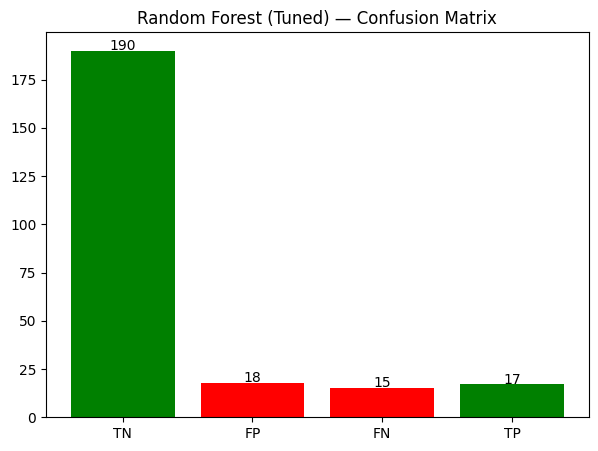

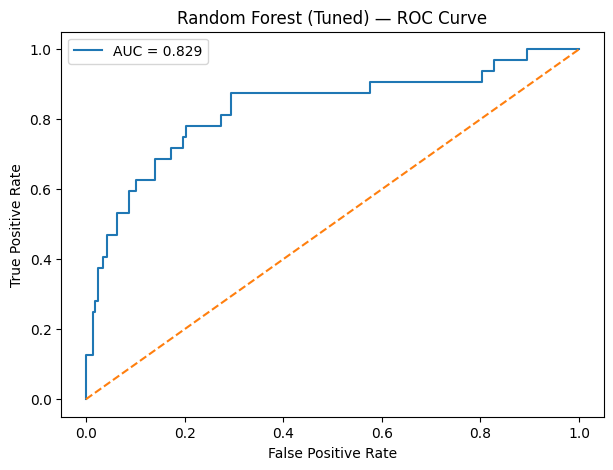

In [16]:
# Get tuned model
best_rf_pipeline = rf_search.best_estimator_

# Predictions + probabilities
rf_val_pred = best_rf_pipeline.predict(X_val)
rf_val_prob = best_rf_pipeline.predict_proba(X_val)[:, 1]
print("RF Validation Accuracy:", accuracy_score(y_val, rf_val_pred))
print("RF Validation F1 (Positive Class):", f1_score(y_val, rf_val_pred,pos_label=1))
print("\nClassification Report:\n", classification_report(y_val, rf_val_pred))

# Visualizations
confusion_bar(y_val, rf_val_pred, "Random Forest (Tuned) — Confusion Matrix")
plot_roc_curve(y_val, rf_val_prob, "Random Forest (Tuned) — ROC Curve")

In [26]:
from sklearn.metrics import recall_score, precision_score

def evaluate_threshold(model_name, y_true, y_prob, thresholds=[0.50, 0.45, 0.40, 0.35, 0.30]):
    print(f"\n=== {model_name}: Threshold Analysis ===")
    results = []

    for t in thresholds:
        y_pred_t = (y_prob >= t).astype(int)

        f1 = f1_score(y_true, y_pred_t, pos_label=1)
        recall = recall_score(y_true, y_pred_t, pos_label=1)
        precision = precision_score(y_true, y_pred_t, pos_label=1)
        
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_t).ravel()

        results.append([t, f1, recall, precision, tp, fp, fn, tn])

        print(f"\nThreshold = {t}")
        print(f"F1 Score:     {f1:.3f}")
        print(f"Recall:       {recall:.3f}")
        print(f"Precision:    {precision:.3f}")
        print(f"TP: {tp},  FP: {fp},  FN: {fn},  TN: {tn}")

    return pd.DataFrame(results, columns=["Threshold", "F1", "Recall", "Precision", "TP", "FP", "FN", "TN"])


In [27]:
rf_threshold_df = evaluate_threshold(
    "Random Forest (Tuned)",
    y_val,
    rf_val_prob
)

rf_threshold_df



=== Random Forest (Tuned): Threshold Analysis ===

Threshold = 0.5
F1 Score:     0.507
Recall:       0.531
Precision:    0.486
TP: 17,  FP: 18,  FN: 15,  TN: 190

Threshold = 0.45
F1 Score:     0.526
Recall:       0.625
Precision:    0.455
TP: 20,  FP: 24,  FN: 12,  TN: 184

Threshold = 0.4
F1 Score:     0.505
Recall:       0.719
Precision:    0.390
TP: 23,  FP: 36,  FN: 9,  TN: 172

Threshold = 0.35
F1 Score:     0.467
Recall:       0.781
Precision:    0.333
TP: 25,  FP: 50,  FN: 7,  TN: 158

Threshold = 0.3
F1 Score:     0.450
Recall:       0.844
Precision:    0.307
TP: 27,  FP: 61,  FN: 5,  TN: 147


,Threshold,F1,Recall,Precision,TP,FP,FN,TN
0,0.50,0.507463,0.53125,0.485714,17,18,15,190
1,0.45,0.526316,0.62500,0.454545,20,24,12,184
2,0.40,0.505495,0.71875,0.389831,23,36,9,172
3,0.35,0.467290,0.78125,0.333333,25,50,7,158
4,0.30,0.450000,0.84375,0.306818,27,61,5,147


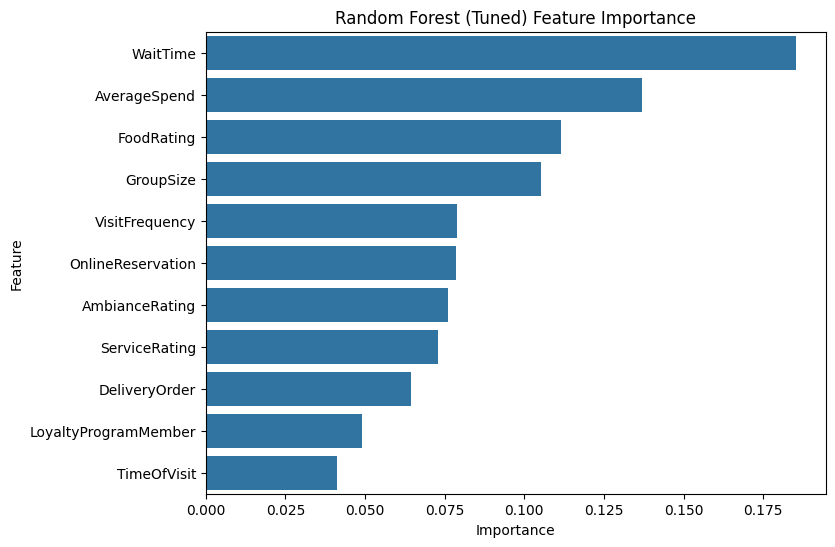

,Feature,Importance
0,WaitTime,0.185356
4,AverageSpend,0.136914
2,FoodRating,0.111566
9,GroupSize,0.105309
5,VisitFrequency,0.078791
7,OnlineReservation,0.078469
3,AmbianceRating,0.075901
1,ServiceRating,0.072909
8,DeliveryOrder,0.064442
6,LoyaltyProgramMember,0.049131


In [18]:
# Extract RF step from pipeline
rf_model = best_rf_pipeline.named_steps["rf"]


# Plot + return importance values
rf_feat_df = plot_feature_importance(rf_model, X_train, "Random Forest (Tuned) Feature Importance")
rf_feat_df

In [19]:
# Same structure as RF: oversampling + model inside pipeline
xgb_pipeline = Pipeline([
    ("oversample", RandomOverSampler(random_state=42)),
    ("xgb", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        tree_method="hist",
        use_label_encoder=False
))
])


# Hyperparameter search space for XGB
xgb_param_dist = {
    "xgb__n_estimators": [200, 300, 400, 500],
    "xgb__max_depth": [3, 4, 5, 6],
    "xgb__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "xgb__subsample": [0.7, 0.8, 0.9, 1.0],
    "xgb__colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "xgb__scale_pos_weight": [1, pos_weight * 0.5, pos_weight, pos_weight * 1.5]
}

# RandomizedSearchCV for XGB
xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_dist,
    n_iter=25,
    scoring=f1_positive,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

xgb_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


/home/md/Downloads/CS539-ML/IP/project_Dacosta/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:11:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/md/Downloads/CS539-ML/IP/project_Dacosta/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:11:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/md/Downloads/CS539-ML/IP/project_Dacosta/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:11:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/md/Downloads/CS539-ML/IP/project_Dacosta/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [23:11:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_en

,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'xgb__colsample_bytree': [0.7, 0.8, ...], 'xgb__learning_rate': [0.01, 0.05, ...], 'xgb__max_depth': [3, 4, ...], 'xgb__n_estimators': [200, 300, ...], ...}"
,n_iter,25
,scoring,"make_scorer(f..., pos_label=1)"
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [34]:
print("Best XGBoost Parameters:")
xgb_search.best_params_

Best XGBoost Parameters:


{'xgb__subsample': 0.7,
 'xgb__scale_pos_weight': 3.2209302325581395,
 'xgb__n_estimators': 500,
 'xgb__max_depth': 4,
 'xgb__learning_rate': 0.05,
 'xgb__colsample_bytree': 1.0}

In [21]:
print("Best XGB CV F1 (Positive Class):", xgb_search.best_score_)

Best XGB CV F1 (Positive Class): 0.49411321171296424


XGB Validation Accuracy: 0.8625
XGB Validation F1: 0.547945205479452

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       208
           1       0.49      0.62      0.55        32

    accuracy                           0.86       240
   macro avg       0.71      0.76      0.73       240
weighted avg       0.88      0.86      0.87       240



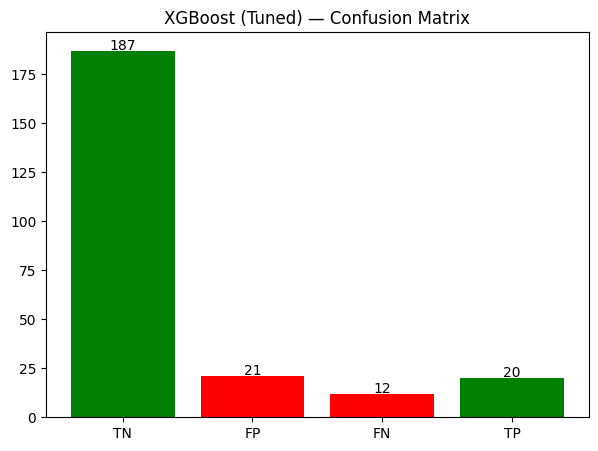

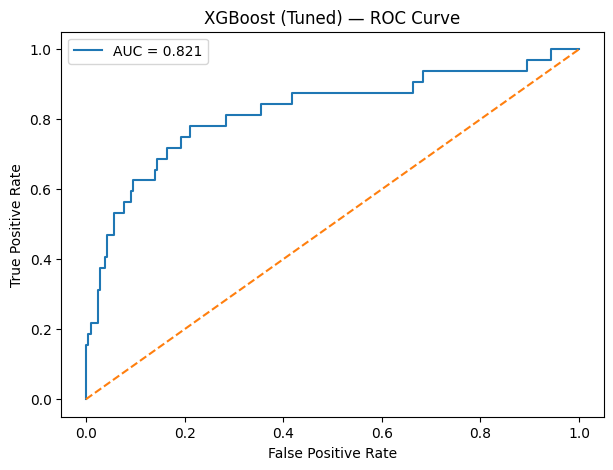

In [33]:
best_xgb_pipeline = xgb_search.best_estimator_

xgb_val_pred = best_xgb_pipeline.predict(X_val)
xgb_val_prob = best_xgb_pipeline.predict_proba(X_val)[:, 1]

print("XGB Validation Accuracy:", accuracy_score(y_val, xgb_val_pred))
print("XGB Validation F1:", f1_score(y_val, xgb_val_pred, pos_label=1))
print("\nClassification Report:\n", classification_report(y_val, xgb_val_pred))


confusion_bar(y_val, xgb_val_pred, "XGBoost (Tuned) — Confusion Matrix")
plot_roc_curve(y_val, xgb_val_prob, "XGBoost (Tuned) — ROC Curve")

In [32]:
xgb_threshold_df = evaluate_threshold(
    "XGBoost (Tuned)",
    y_val,
    xgb_val_prob
)

xgb_threshold_df



=== XGBoost (Tuned): Threshold Analysis ===

Threshold = 0.5
F1 Score:     0.548
Recall:       0.625
Precision:    0.488
TP: 20,  FP: 21,  FN: 12,  TN: 187

Threshold = 0.45
F1 Score:     0.533
Recall:       0.625
Precision:    0.465
TP: 20,  FP: 23,  FN: 12,  TN: 185

Threshold = 0.4
F1 Score:     0.526
Recall:       0.625
Precision:    0.455
TP: 20,  FP: 24,  FN: 12,  TN: 184

Threshold = 0.35
F1 Score:     0.512
Recall:       0.656
Precision:    0.420
TP: 21,  FP: 29,  FN: 11,  TN: 179

Threshold = 0.3
F1 Score:     0.512
Recall:       0.688
Precision:    0.407
TP: 22,  FP: 32,  FN: 10,  TN: 176


,Threshold,F1,Recall,Precision,TP,FP,FN,TN
0,0.50,0.547945,0.62500,0.487805,20,21,12,187
1,0.45,0.533333,0.62500,0.465116,20,23,12,185
2,0.40,0.526316,0.62500,0.454545,20,24,12,184
3,0.35,0.512195,0.65625,0.420000,21,29,11,179
4,0.30,0.511628,0.68750,0.407407,22,32,10,176


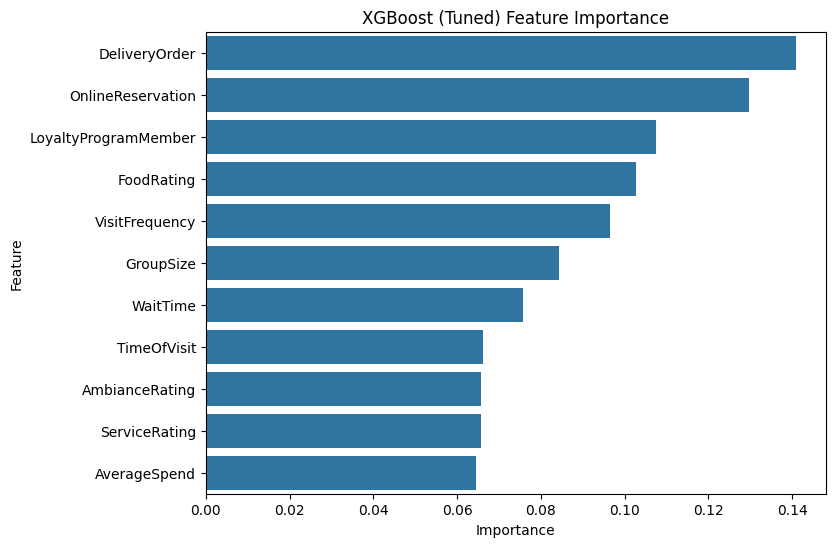

,Feature,Importance
8,DeliveryOrder,0.141012
7,OnlineReservation,0.129793
6,LoyaltyProgramMember,0.107613
2,FoodRating,0.102723
5,VisitFrequency,0.096574
9,GroupSize,0.084437
0,WaitTime,0.075674
10,TimeOfVisit,0.066204
3,AmbianceRating,0.065756
1,ServiceRating,0.065706


In [29]:
xgb_model = best_xgb_pipeline.named_steps["xgb"]

xgb_feat_df = plot_feature_importance(xgb_model, X_train, "XGBoost (Tuned) Feature Importance")
xgb_feat_df

In [30]:
# Identify rows the models struggled with
rf_misclassified = X_val[y_val != rf_val_pred]
xgb_misclassified = X_val[y_val != xgb_val_pred]

print("Random Forest - Sample Misclassifications:")
rf_misclassified.head()

Random Forest - Sample Misclassifications:


,WaitTime,ServiceRating,FoodRating,AmbianceRating,AverageSpend,VisitFrequency,LoyaltyProgramMember,OnlineReservation,DeliveryOrder,GroupSize,TimeOfVisit
654,4.718618,2,1,5,61.008259,4,1,0,1,1,3
248,2.746688,2,1,5,180.921551,4,1,1,1,7,2
452,35.766639,2,4,5,136.450946,3,1,1,0,6,1
219,7.412754,2,5,1,100.054897,3,1,0,0,4,1
1037,12.699771,4,3,4,57.251289,4,0,0,0,1,2


In [31]:
print("XGBoost - Sample Misclassifications:")
xgb_misclassified.head()

XGBoost - Sample Misclassifications:


,WaitTime,ServiceRating,FoodRating,AmbianceRating,AverageSpend,VisitFrequency,LoyaltyProgramMember,OnlineReservation,DeliveryOrder,GroupSize,TimeOfVisit
654,4.718618,2,1,5,61.008259,4,1,0,1,1,3
452,35.766639,2,4,5,136.450946,3,1,1,0,6,1
878,4.311843,5,3,3,149.345154,3,0,0,1,6,1
219,7.412754,2,5,1,100.054897,3,1,0,0,4,1
1037,12.699771,4,3,4,57.251289,4,0,0,0,1,2
